In [2]:
import os
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from models.CPD_ResNet_models import CPD_ResNet

In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(
    gpu,
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]
)

In [4]:
m = CPD_ResNet()
m.load_state_dict(torch.load('CPD-R.pth'))
# m.cuda()
m.eval()

#显著性特征提取
def extract_features(tfTensor):
    if tfTensor.shape[0] is not None:
        torchTensor = torch.Tensor(tf.transpose(tfTensor, [0, 3, 1, 2]).numpy())
        featureList = m(torchTensor)
        newList = []
        for feature in featureList:
            feature = feature.permute(0, 2, 3, 1).sigmoid().detach().numpy()
            newList.append(feature)
        return newList

In [5]:
def readImg(imgName):
    img = tf.io.read_file(imgName)
    img = tf.io.decode_image(img, dtype=tf.float32)
    return img

In [6]:
def showImg(img):
    plt.imshow(tf.squeeze(img), cmap='binary')
    plt.axis('off')
    plt.show()

In [7]:
#对应网络的两个池化
def pool_and_concat(X):
    avgP = tf.nn.avg_pool2d(X, ksize=2, strides=2, padding='VALID', data_format='NHWC')
    maxP = tf.nn.max_pool2d(X, ksize=2, strides=2, padding='VALID', data_format='NHWC')
    return tf.concat([avgP, maxP], -1)

#注意力网络
class Attention_net(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.block1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=8, kernel_size=1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ])
        self.block2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=1),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=4, kernel_size=1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ])
        self.block3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=2, strides=2)
        ])
        self.block4 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=4, kernel_size=3, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=4, kernel_size=1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=2, strides=2)
        ])
        self.block5 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=3, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()
        ])

    def call(self, X):
        Y_c1 = self.block1(X)
        Y = pool_and_concat(Y_c1)
        Y_c2 = self.block2(Y)
        Y = pool_and_concat(Y_c2)
        Y = self.block3(Y)
        Y += Y_c2
        Y = self.block4(Y)
        Y += Y_c1
        return self.block5(Y)

In [8]:
class SFT_layer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.block1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ])
        self.block2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ])

    def call(self, X, F):
        return X * self.block1(F) + self.block2(F)

In [9]:
#SFT块
class SFT_block(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.preprossNet = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        ])
        self.layer1 = SFT_layer()
        self.layer2 = SFT_layer()
        # self.layer3 = SFT_layer()
        # self.layer4 = SFT_layer()
        # self.layer5 = SFT_layer()
        self.featureList = []
    def call(self, X):
        #特征是一个列表，对应显著性检测网络的最终两个输出
        self.featureList = extract_features(X)
        X = self.layer1(self.preprossNet(X), self.featureList[0])
        X = self.layer2(X, self.featureList[1])
        # X = self.layer3(X, self.featureList[0])
        # X = self.layer4(X, self.featureList[1])
        # Y = self.layer5(X, self.featureList[0])
        return X

In [10]:
#完整的一个阶段（无视觉显著性驱动）
class resBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.net = Attention_net()
        self.preprossNet = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        ])

    def call(self, X):
        Y = self.net(self.preprossNet(X))
        Y *= X
        Y += X
        return Y

In [11]:
#有视觉显著性驱动
class resBlockV2(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.block = SFT_block()
        self.net = Attention_net()
    def call(self, X):
        Y = self.block(X)
        Y = self.net(Y)
        Y *= X
        Y += X
        # print(Y)
        return Y

In [12]:
#生成数据集
def geneDataSet(dir_X, dir_Y):
    fileList_X = os.listdir(dir_X)
    X_list = []
    Y_list = []
    for file in fileList_X:
        fileNameX = os.path.join(dir_X, file)
        imgX = readImg(fileNameX)
        X_list.append(imgX)
        fileNameY = os.path.join(dir_Y, file)
        imgY = readImg(fileNameY)
        Y_list.append(imgY)
    train_data = (X_list, Y_list)
    return tf.data.Dataset.from_tensor_slices(train_data).batch(2)

In [13]:
train_iter = geneDataSet("./pic/train_X", "./pic/train_Y")

In [143]:
net = tf.keras.Sequential([
    resBlock(),
    resBlock()
])

In [146]:
net.load_weights('weightV1_2_epoch10.h5')

In [215]:
netV2 = tf.keras.Sequential([
    resBlockV2(),
    resBlockV2(),
    resBlockV2(),
])

In [217]:
netV2.load_weights('weightsV2_3_epoch5.h5')

In [144]:
#训练（一个epoch）
loss = tf.keras.losses.MeanSquaredError()
trainer = tf.keras.optimizers.Adam(learning_rate=0.001)
i = 0
total_loss = 0
loss_list111 = []
for _ in range(100):
    j = 0
    for x, y in train_iter:
        with tf.GradientTape() as tape:
            y_hat = net(x)
            l = loss(y, y_hat)
            w = net.trainable_variables
            #     g = tape.gradient(l, w)
            #     trainer.apply_gradients([(g, w)])
        trainer.minimize(l, w, tape=tape)
        i += 1
        j += 1
        total_loss += l.numpy()

        if i % 10 == 0:
            print('epoch' + str(_) + '[' + '=' * (j // 10) + '>' + ' ' * (25 - j // 10) + ']' + 'loss:', total_loss / i)
    loss_list111.append(total_loss / i)
# plt.plot(loss_list)
print('ok')

epoch0[=>                        ]loss: 0.07613784614950418
epoch0[==>                       ]loss: 0.07464930051937699
epoch0[===>                      ]loss: 0.08990864679217339
epoch0[====>                     ]loss: 0.08349710134789348
epoch0[=====>                    ]loss: 0.07708498757332563
epoch0[======>                   ]loss: 0.06927837617695332
epoch0[=======>                  ]loss: 0.06720365936468754


KeyboardInterrupt: 

In [ ]:
for _ in range(500)

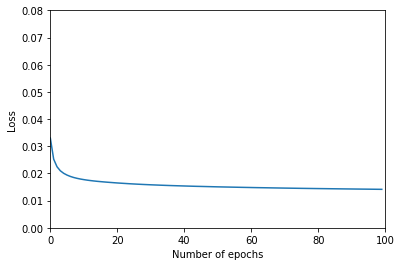

In [169]:
plt.xlim(0, 100)
plt.ylim(0, 0.08)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.plot(loss_list[:100])
plt.savefig('../ppt/process100.jpg')

In [75]:
def geneMap(img, imgh, filePath):
    imgm = (imgh - img) / (img + 0.01)
    imgm = tf.clip_by_value(imgm / np.max(imgm), 0, 1)
    imgm = tf.squeeze(tf.reduce_mean(imgm, 3, keepdims=True), 0)
    plt.imsave(filePath, tf.squeeze(imgm), cmap='gray')
    plt.imshow(imgm, cmap='gray')
    plt.axis('off')
    plt.show()

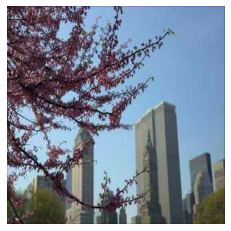

In [218]:
imgNum = '4753'
img = readImg(f'../papertest_X/{imgNum}.jpg')
img = tf.expand_dims(img, 0)
imgh = tf.clip_by_value(netV2(img), 0, 1)
plt.imsave(f'../ppt/{imgNum}_3.jpg', tf.squeeze(imgh).numpy())
# geneMap(img, imgh, f'../ppt/{imgNum}_map.jpg')
showImg(imgh)

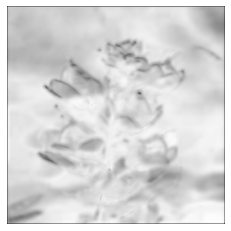

In [106]:
geneMap(img, imgh, '../ppt/2563_map.jpg')

In [51]:
net.save_weights('weightV1_2_epoch10.h5')

In [63]:
import numpy as np

In [66]:
mmm = (imgh - img) / (img + 0.01)
mm = np.max(mmm)
mm

1.6945217